# Creating stacked autoencoder from single autoencoder unit by stacking method 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


float64
float64
[0. 1. 1. ... 0. 0. 0.]
training autoencoder: 0
epochs to do: 2
epoch: 0
j / n_batches: 0 / 15 cost: 0.43042090643709785
j / n_batches: 10 / 15 cost: -1.8667831920967461
epoch: 1
j / n_batches: 0 / 15 cost: -2.9611559612049034
j / n_batches: 10 / 15 cost: -12.432021772135903


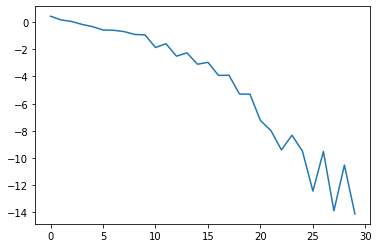

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[20]:


from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix as cm
import theano
import theano.tensor as T



# !pip install theano



def get_data(path):
    df = pd.read_excel(path)
    cols = list(df.columns)
    col_x = cols[1:-1]
    col_y = cols[-1]
    mu = df[col_x].mean(axis=0)
    std = df[col_x].std(axis=0)
    df[col_x] = (df[col_x]-mu)/std
    X = df[col_x].values
    Y = df[col_y]
    names = list(set(Y))
    K = len(names)
    N = len(Y)
    namestoint = dict({name:i for i,name in enumerate(names)})
    T = np.zeros((N, K))
    for i in range(N):
        T[i, namestoint[Y[i]]] = 1
    X = np.float64(X)
    T = np.float64(Y)
    print(X.dtype)
    print(T.dtype)
    print(T)
    return X,T




def relu(x):
    return x * (x > 0)


def error_rate(p, t):
    return np.mean(p != t)

def init_weights(shape):
    w = np.random.randn(*shape) / np.sqrt(sum(shape))
    return w.astype(np.float64)


# In[33]:


def T_shared_zeros_like32(p):
    return theano.shared(np.zeros_like(p.get_value(),dtype=np.float64))

def momentum_updates(cost,params,mu,learning_rate):
    dparams = [T_shared_zeros_like32(p) for p in params]
    updates = []
    grads = T.grad(cost,params)
    for p,dp,g in zip(params,dparams,grads):
        dp_update = mu*dp-learning_rate*g
        p_update=p+dp_update
        updates.append((dp,dp_update))
        updates.append((p,p_update))
    return updates


# In[44]:


class AutoEncoder(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id

    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=False):
        # cast to float
        mu = np.float64(mu)
        learning_rate = np.float64(learning_rate)

        N, D = X.shape
        n_batches = N // batch_sz

        W0 = init_weights((D, self.M))
        self.W = theano.shared(W0, 'W_%s' % self.id)
        self.bh = theano.shared(np.zeros(self.M, dtype=np.float64), 'bh_%s' % self.id)
        self.bo = theano.shared(np.zeros(D, dtype=np.float64), 'bo_%s' % self.id)
        self.params = [self.W, self.bh, self.bo]
        self.forward_params = [self.W, self.bh]

        # TODO: technically these should be reset before doing backprop
        self.dW = theano.shared(np.zeros(W0.shape, dtype=np.float64), 'dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M, dtype=np.float64), 'dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D, dtype=np.float64), 'dbo_%s' % self.id)
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]

        X_in = T.matrix('X_%s' % self.id)
        X_hat = self.forward_output(X_in)

        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,
            allow_input_downcast=True,
        )

        # save this for later so we can call it to
        # create reconstructions of input
        self.predict = theano.function(
            inputs=[X_in],
            outputs=X_hat,
            allow_input_downcast=True,
        )

        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).flatten().mean()
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
            allow_input_downcast=True,
        )

        

        updates = momentum_updates(cost, self.params, mu, learning_rate)
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,
            allow_input_downcast=True,
        )

        costs = []
        print("training autoencoder: %s" % self.id)
        print("epochs to do:", epochs)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(batch) # technically we could also get the cost for Xtest here
                if j % 10 == 0:
                    print("j / n_batches:", j, "/", n_batches, "cost:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        return Z

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(np.float64(W), 'W_%s' % ae.id)
        ae.bh = theano.shared(np.float64(bh), 'bh_%s' % ae.id)
        ae.bo = theano.shared(np.float64(bo), 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae


# In[45]:

class DNN(object):
    def __init__(self, hidden_layer_sizes, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1


    def fit(self, X, Y, Xtest, Ytest,
        pretrain=True,
        train_head_only=False,
        learning_rate=0.1,
        mu=0.99,
        reg=0.0,
        epochs=1,
        batch_sz=100):

        # cast to float32
        learning_rate = np.float64(learning_rate)
        mu = np.float64(mu)
        reg = np.float64(reg)

        # greedy layer-wise training of autoencoders
        pretrain_epochs = 2
        if not pretrain:
            pretrain_epochs = 0

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.hidden_op(current_input)

        # initialize logistic regression layer
        N = len(Y)
        # K = len(set(Y))
        K = len(np.unique(Y))
        W0 = init_weights((self.hidden_layers[-1].M, K))
        self.W = theano.shared(W0, "W_logreg")
        self.b = theano.shared(np.zeros(K, dtype=np.float64), "b_logreg")

        self.params = [self.W, self.b]
        if not train_head_only:
            for ae in self.hidden_layers:
                self.params += ae.forward_params

        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')


        pY = self.forward(X_in)

        squared_magnitude = [(p*p).sum() for p in self.params]
        reg_cost = T.sum(squared_magnitude)
        
        cost = -T.mean( T.log(pY[T.arange(pY.shape[0]), targets]) ) + reg*reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],
            allow_input_downcast=True,
        )

        updates = momentum_updates(cost, self.params, mu, learning_rate)
        train_op = theano.function(
            inputs=[X_in, targets],
            updates=updates,
            allow_input_downcast=True,
        )

        n_batches = N // batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                print("j / n_batches:", j, "/", n_batches, "cost:", the_cost, "error:", error)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

def test_single_autoencoder(path,train_split=0.7):
    X,Y = get_data(path)
    X,Y = shuffle(X,Y)
    split_idx = int(train_split*len(X))
    Xtrain = X[:split_idx]
    Ytrain = Y[:split_idx]
    Xtest = X[split_idx:]
    Ytest = Y[split_idx:]
    Xtrain = np.float64(Xtrain)
    Xtest = np.float64(Xtest)
    # print(Xtrain.dtype)
    # print(Xtest.dtype)
    autoencoder = AutoEncoder(300, 0)
    autoencoder.fit(Xtrain, epochs=2, show_fig=True)

    x = Xtest
    y = autoencoder.predict(x)
    # print(f"x.shape:-{x.shape}")
    # print(f"y.shape:-{y.shape}")
    
    
def test_stacked_autoencoder(path,train_split=0.7):
    X,Y = get_data(path)
    X,Y = shuffle(X,Y)
    split_idx = int(train_split*len(X))
    Xtrain = X[:split_idx]
    Ytrain = Y[:split_idx]
    Xtest = X[split_idx:]
    Ytest = Y[split_idx:]
    Xtrain = np.float64(Xtrain)
    Xtest = np.float64(Xtest)
    
    stacked_ae = DNN([1000,750,500])
    stacked_ae.fit(Xtrain,Ytrain,Xtest,Ytest,pretrain=True,train_head_only=False,epochs=3)



path = r"C:\\Users\\gprak\\Downloads\\BITS Courses\\CS F464 Machine Learning I - Completed\\data\\data5.xlsx"

# test_single_autoencoder(path)








float64
float64
[0. 1. 1. ... 0. 0. 0.]
training autoencoder: 0
epochs to do: 2
epoch: 0
j / n_batches: 0 / 15 cost: 0.11855347854018201
j / n_batches: 10 / 15 cost: -4.207952717585228
epoch: 1
j / n_batches: 0 / 15 cost: -8.524779275425683
j / n_batches: 10 / 15 cost: -33.95626031071839
training autoencoder: 1
epochs to do: 2
epoch: 0
j / n_batches: 0 / 15 cost: 0.6852345949910872
j / n_batches: 10 / 15 cost: 0.5826683739521276
epoch: 1
j / n_batches: 0 / 15 cost: 0.5706963758167938
j / n_batches: 10 / 15 cost: 0.41664201398990763
training autoencoder: 2
epochs to do: 2
epoch: 0
j / n_batches: 0 / 15 cost: 0.6882183045771673
j / n_batches: 10 / 15 cost: 0.37151835914309295
epoch: 1
j / n_batches: 0 / 15 cost: 0.4272151038286652
j / n_batches: 10 / 15 cost: 0.42541757728005597
supervised training...
epoch: 0
j / n_batches: 0 / 15 cost: 2.3208074181265745 error: 0.4868217054263566
j / n_batches: 1 / 15 cost: 2.5153503016620826 error: 0.5131782945736434
j / n_batches: 2 / 15 cost: 0.7126

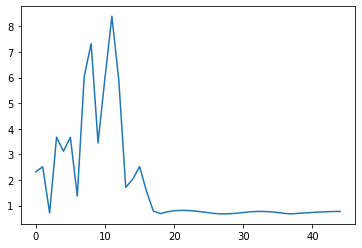

In [2]:
test_stacked_autoencoder(path)
